Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


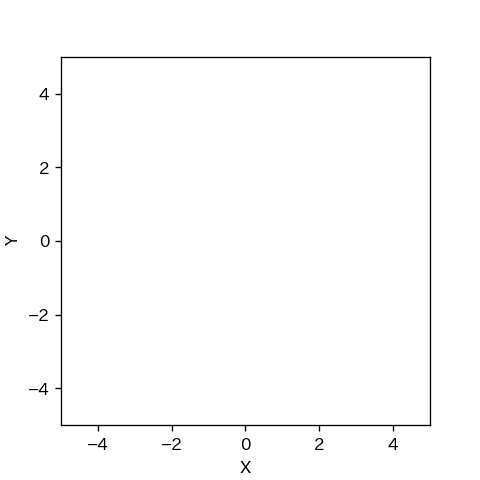

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_trap_phantom(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([0,0,0]).T
    robot_pose = np.array([0,0,0]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m,phantom_prob=0.1), agent=a, color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_phantom(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [-0.53325486  2.28799788  3.437429  ] 推定値: [-3.73980724 -1.16668093  1.87090955] 誤差: 4.713468347744662
1 真値: [1.03157589 1.8838863  2.29208991] 推定値: [-0.78580948 -2.42760421  1.27219769] 誤差: 4.678871658614089
2 真値: [1.16116904 2.50996868 2.08203484] 推定値: [1.73074146 1.09863669 1.14849785] 誤差: 1.5219299341170405
3 真値: [0.12781098 2.05870118 2.92880692] 推定値: [-4.55367182  6.82732197 -1.68246548] 誤差: 6.682516395527266
4 真値: [-0.34757065  1.94696945  3.42725097] 推定値: [-4.14257042  5.54925022 -1.3227785 ] 誤差: 5.232442063460377
5 真値: [0.97467092 0.79768811 1.22946123] 推定値: [-0.14416453  3.51402221  0.13794268] 誤差: 2.9377310491131126
6 真値: [1.10757917 0.51790383 0.8911066 ] 推定値: [5.90450762 2.20535697 2.78003403] 誤差: 5.085078231238741
7 真値: [-0.49185475  1.52175836  3.91093362] 推定値: [-0.70542303  2.67410076 -2.10697949] 誤差: 1.1719660438550823
8 真値: [0.49578355 1.71108018 2.46709945] 推定値: [-1.19566998 -0.4478086   1.73281407] 誤差: 2.7425928990466972
9 真値: [1.58573462 1.3546789  1.41875793

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-1.37079803  1.84161518  4.34979326] 推定値: [ 7.14391172  0.51454018 -3.47237882] 誤差: 8.617506028828354
21 真値: [-0.15715866  1.9517865   3.21580315] 推定値: [-5.06780214  5.63002975 -1.17981011] 誤差: 6.135461899290226
22 真値: [0.27302384 1.89803881 2.8142544 ] 推定値: [-0.72000613 -1.15130241  2.0324394 ] 誤差: 3.2069596849443784
23 真値: [0.82630446 0.673065   1.35303297] 推定値: [ 5.40148231  5.16489056 -1.9666368 ] 誤差: 6.411610496734494
24 真値: [1.42626209 1.82074352 1.70144988] 推定値: [-5.65148561  1.42112959  1.3818925 ] 誤差: 7.08901994089033
25 真値: [1.17947873 1.56649843 1.80725833] 推定値: [0.06863077 0.14059367 1.8138723 ] 誤差: 1.8075363272333913
26 真値: [-0.055895    2.00469031  3.04841562] 推定値: [-0.67483961  0.99907946  2.74702269] 誤差: 1.1808241214399728
27 真値: [0.19865664 2.01000402 2.86176306] 推定値: [-8.08436108  2.58246294 -0.41269925] 誤差: 8.302776142587545
28 真値: [1.19072373 2.66917556 2.29597724] 推定値: [ 0.32147789 -0.32879751  1.65543233] 誤差: 3.1214469177198243
29 真値: [-0.94075664  1.36887